<a href="https://colab.research.google.com/github/rahulbdass/computer_vision_project/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q mlcroissant

In [3]:
!pip install -q fiftyone

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import textwrap
import os
from google.colab import drive

from mlcroissant import Dataset

In [ ]:
# for coco dataset
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

### COCO/TFDS

In [ ]:
ds, ds_info = tfds.load('coco_captions', split='test', with_info=True)

In [ ]:
record_sets = ds.metadata.record_sets
print(record_sets)

In [ ]:
record_set_df = pd.DataFrame(ds.records(record_set=record_sets[0].uuid))
record_set_df.head()
record_set_df.info()

### Flickr30k/Croissant

In [5]:
# Download Flickr30k metadata from hugging face
flickr30k_ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
records = flickr30k_ds.records("TEST")
records

  -  [Metadata(flickr30k)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/version" is recommended, but does not exist.


Records(dataset=Dataset(jsonld='https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant', operations=OperationGraph(issues=Issues(_errors=set(), _warnings={('Property "https://schema.org/datePublished" is recommended, but does not exist.', Metadata(uuid="_:Nf945486443d74a09a828b52a4883e03d")), ('Property "https://schema.org/license" is recommended, but does not exist.', Metadata(uuid="_:Nf945486443d74a09a828b52a4883e03d")), ('Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.', Metadata(uuid="_:Nf945486443d74a09a828b52a4883e03d")), ('Property "https://schema.org/version" is recommended, but does not exist.', Metadata(uuid="_:Nf945486443d74a09a828b52a4883e03d"))}), operations=<mlcroissant._src.operation_graph.base_operation.Operations object at 0x7dc3794f4cd0>), metadata=Metadata(uuid="_:Nf945486443d74a09a828b52a4883e03d"), debug=False, mapping=None), record_set='TEST', filters=None, debug=False)

In [6]:
# Print the names of the available record sets
record_sets = flickr30k_ds.metadata.record_sets
print(record_sets)

[RecordSet(uuid="TEST")]


In [7]:
# Load the image metadata and captions into a dataframe
# NOTE: This does not actually load the images, just a pointer to them
flickr30k_df = pd.DataFrame(flickr30k_ds.records(record_set=record_sets[0].uuid))
display(flickr30k_df.head())
flickr30k_df.info()

,TEST/image,TEST/caption,TEST/sentids,TEST/split,TEST/img_id,TEST/filename
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Two young guys with shaggy hair look at the...,"[b'0', b'1', b'2', b'3', b'4']",b'train',b'0',b'1000092795.jpg'
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Several men in hard hats are operating a gi...,"[b'5', b'6', b'7', b'8', b'9']",b'train',b'1',b'10002456.jpg'
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A child in a pink dress is climbing up a se...,"[b'10', b'11', b'12', b'13', b'14']",b'train',b'2',b'1000268201.jpg'
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Someone in a blue shirt and hat is standing...,"[b'15', b'16', b'17', b'18', b'19']",b'train',b'3',b'1000344755.jpg'
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[b'Two men, one in a gray shirt, one in a blac...","[b'20', b'21', b'22', b'23', b'24']",b'train',b'4',b'1000366164.jpg'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TEST/image     31014 non-null  object
 1   TEST/caption   31014 non-null  object
 2   TEST/sentids   31014 non-null  object
 3   TEST/split     31014 non-null  object
 4   TEST/img_id    31014 non-null  object
 5   TEST/filename  31014 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [25]:
#Preprocess Captions:
def preprocess_captions(flickr30k_df):
  for index, row in flickr30k_df.iterrows():
    caption = str(row["TEST/caption"][0])
    #remove b' in each caption
    caption = caption[2:]
    #Convert Caption to lowercase
    caption = caption.lower()
    #Delete digits and special chars
    caption = caption.replace("[^A-Za-z]", "")
    #Remove extra spaces
    caption = caption.replace("\s+", " ")
    #remove all single letter words in caption
    caption = "<start> " + " ".join([word for word in caption.split() if len(word)>1]) + " <end>"
    flickr30k_df.at[index, "TEST/preprocessed_caption"] = caption

In [26]:
preprocess_captions(flickr30k_df)

In [27]:
display(flickr30k_df.head())
flickr30k_df.info()

,TEST/image,TEST/caption,TEST/sentids,TEST/split,TEST/img_id,TEST/filename,TEST/preprocessed_caption
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Two young guys with shaggy hair look at the...,"[b'0', b'1', b'2', b'3', b'4']",b'train',b'0',b'1000092795.jpg',<start> two young guys with shaggy hair look a...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Several men in hard hats are operating a gi...,"[b'5', b'6', b'7', b'8', b'9']",b'train',b'1',b'10002456.jpg',<start> several men in hard hats are operating...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A child in a pink dress is climbing up a se...,"[b'10', b'11', b'12', b'13', b'14']",b'train',b'2',b'1000268201.jpg',<start> child in pink dress is climbing up set...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Someone in a blue shirt and hat is standing...,"[b'15', b'16', b'17', b'18', b'19']",b'train',b'3',b'1000344755.jpg',<start> someone in blue shirt and hat is stand...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[b'Two men, one in a gray shirt, one in a blac...","[b'20', b'21', b'22', b'23', b'24']",b'train',b'4',b'1000366164.jpg',"<start> two men, one in gray shirt, one in bla..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   TEST/image                 31014 non-null  object
 1   TEST/caption               31014 non-null  object
 2   TEST/sentids               31014 non-null  object
 3   TEST/split                 31014 non-null  object
 4   TEST/img_id                31014 non-null  object
 5   TEST/filename              31014 non-null  object
 6   TEST/preprocessed_caption  31014 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


In [8]:
np.unique(flickr30k_df["TEST/split"])

array([b'test', b'train', b'val'], dtype=object)

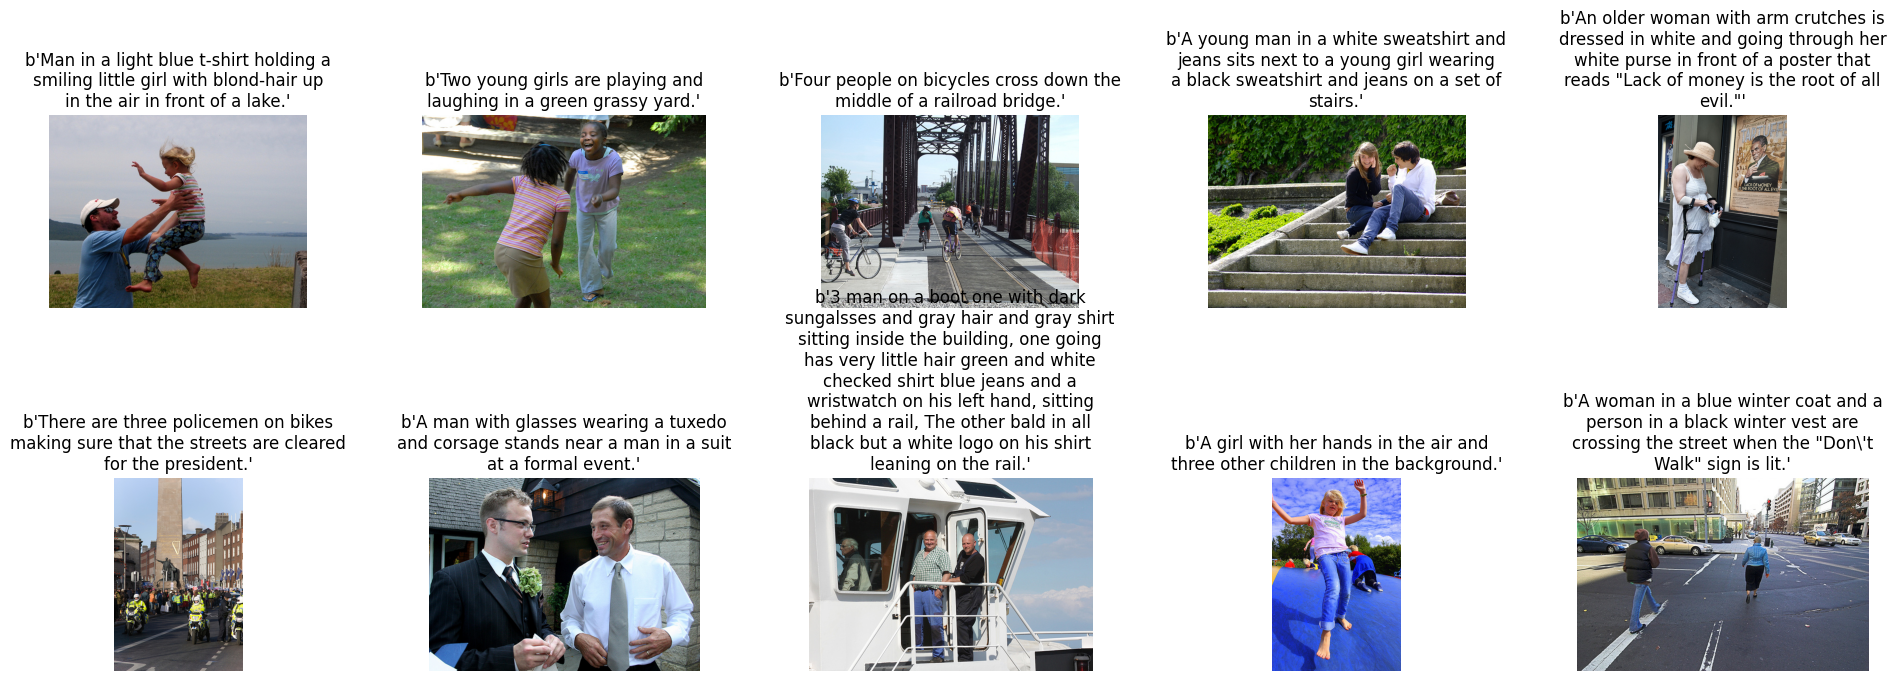

In [9]:
# Print a random sample of 10 images and their captions
rs = flickr30k_df.sample(n=10)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axs = axs.flatten()

for i, ax in enumerate(axs):
  ax.imshow(rs["TEST/image"].iloc[i])
  caption = str(rs["TEST/caption"].iloc[i][0])
  ax.set_title(textwrap.fill(caption, width=40))
  ax.set_axis_off()

fig.tight_layout(pad=5.0)
plt.show()

In [10]:
# Split data into train test and val sets
train_df = flickr30k_df[flickr30k_df["TEST/split"] == b'train']
print(train_df.info())

test_df = flickr30k_df[flickr30k_df["TEST/split"] == b'test']
print(test_df.info())

val_df = flickr30k_df[flickr30k_df["TEST/split"] == b'val']
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29000 entries, 0 to 31013
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TEST/image     29000 non-null  object
 1   TEST/caption   29000 non-null  object
 2   TEST/sentids   29000 non-null  object
 3   TEST/split     29000 non-null  object
 4   TEST/img_id    29000 non-null  object
 5   TEST/filename  29000 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 25 to 30943
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TEST/image     1000 non-null   object
 1   TEST/caption   1000 non-null   object
 2   TEST/sentids   1000 non-null   object
 3   TEST/split     1000 non-null   object
 4   TEST/img_id    1000 non-null   object
 5   TEST/filename  1000 non-null   object
dtypes: object(6)
memory usage: 54.7+ KB
None
<class 'pandas.

In [ ]:
# NOTE: I am commenting this section out for now because this method of preprocessing will crash due to loading all the images into memory at once


# subset_df = record_set_df.sample(frac=0.01, random_state=42)
# subset_df.info()

In [ ]:
# print(*(caption for caption in subset_df["TEST/caption"].iloc[3]), sep='\n')
# subset_df["TEST/image"].iloc[3]

In [ ]:
# for i in range(len(record_set_df)):
#   print(i)
#   print(plt.imshow(record_set_df["TEST/image"].iloc[i]))
#   plt.show()

In [ ]:
# # Define a resizing function for PIL images
# def preprocess_image(pil_image):
#     img = tf.convert_to_tensor(pil_image)  # Convert PIL image to tensor
#     img = tf.image.resize(img, [224, 224])  # Resize to target dimensions
#     img = img / 255.0  # Scale pixel values to [0, 1] range
#     return img

# # Apply the function to each image in your DataFrame
# subset_df['resized_image'] = subset_df['TEST/image'].apply(preprocess_image)


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((list(subset_df['resized_image']), list(subset_df['TEST/caption'])))
# batch_size = 32
# dataset = dataset.batch(batch_size).shuffle(buffer_size=100)
# print(dataset.element_spec)

In [ ]:
# for batch in dataset.take(1):
#   images, captions = batch
#   for image, image_captions in zip(images[:3], captions[:3]):
#     print(image_captions)
#     plt.imshow(image)
#     plt.show()

In [11]:
# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator_from_croissant(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)
    images = data["TEST/image"]
    image_tensors = [tf.convert_to_tensor(img) for img in images]
    image_tensors = [tf.image.resize(img, [im_width, im_height]) for img in image_tensors]
    image_tensors = [img/255.0 for img in image_tensors]
    yield np.array(image_tensors)

In [12]:
import random

In [13]:
train_df["TEST/caption"].iloc[0][4]

b'Two friends enjoy time spent together.'

In [14]:
idx = 10
bs = 64
low = idx * bs
high = min(low + bs, len(train_df))
batch = train_df[low:high]

In [15]:
batch.head()

,TEST/image,TEST/caption,TEST/sentids,TEST/split,TEST/img_id,TEST/filename
702,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A dog is wearing a red number 6 and running...,"[b'3510', b'3511', b'3512', b'3513', b'3514']",b'train',b'702',b'1240297429.jpg'
703,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A woman in a brown shirt is about to releas...,"[b'3515', b'3516', b'3517', b'3518', b'3519']",b'train',b'703',b'124106477.jpg'
704,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[b'Two men, one looking at a screen with a dru...","[b'3520', b'3521', b'3522', b'3523', b'3524']",b'train',b'704',b'124145159.jpg'
705,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A large brown horse stands over a small bla...,"[b'3525', b'3526', b'3527', b'3528', b'3529']",b'train',b'705',b'124195430.jpg'
706,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A young boy watching and admiring puppets i...,"[b'3530', b'3531', b'3532', b'3533', b'3534']",b'train',b'706',b'1242394484.jpg'


In [16]:
class CroissantDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, df, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __getitem__(self, idx):
    #batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]

    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))
    batch = self.data[low:high]

    images = batch["TEST/image"]
    image_tensors = [tf.convert_to_tensor(img) for img in images]
    image_tensors = [tf.image.resize(img, [self.im_width, self.im_height]) for img in image_tensors]
    image_tensors = [img/255.0 for img in image_tensors]

    caption_idx = random.randint(0, 4)
    #captions = []
    #captions = batch["TEST/caption"][caption_idx]

    return np.array(image_tensors)

  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

In [17]:
train_generator = CroissantDataGenerator(train_df, 224, 224, batch_size=64)

In [18]:
np.ceil(len(train_df)/64)

454.0

In [19]:
next(data_generator_from_croissant(train_df, 224, 224, batch_size=64)).shape

(64, 224, 224, 3)

In [ ]:
# plt.imshow(next(data_generator_from_croissant(train_df, 128, 128, batch_size=64))[0])

In [1]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
batch_size = 5
batches_per_epoch = int(np.ceil(len(train_df)/batch_size))
num_epochs = 10

train_generator = data_generator_from_croissant(train_df, 224, 224, batch_size=64)

test_start_time = time.time()
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")
  epoch_start_time = time.time()

  for batch_idx in range(batches_per_epoch):
    batch = next(train_generator)

  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

NameError: name 'np' is not defined

In [ ]:
(test_end_time - test_start_time)/60

### COCO/FiftyOne

In [ ]:
# Using coco dataset with FiftyOne
# https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

feature_classes = ["person", "car", "truck"]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=feature_classes,
    max_samples=100,
)

session = fo.launch_app(dataset)

In [ ]:
# dataset.get_field_schema()
field_names = list(dataset.get_field_schema().keys())
print(field_names)
display(dataset.first())

In [ ]:
coco_ds = dataset.take(100, seed=222)
print(coco_ds)

In [ ]:
print(coco_ds.first().field_names)

In [ ]:
rand_samples_ds.distinct("ground_truth.detections.label")


In [ ]:
# Load model from zoo and apply it to dataset
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions")

# Evaluate `predictions` w.r.t. labels in `ground_truth` field
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True,
)

# Print the mAP
print("mean Average Precision", results.mAP())
session = fo.launch_app(dataset)

# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
# View patches in the App
session.view = eval_patches

In [ ]:
! cd